In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
parquet_table = pq.read_table(r'X:\DS\NYC MLOPS\data\remote\fhvhv_tripdata_2023-01.parquet')
# parquet_table = pq.read_table(r'X:\DS\NYC MLOPS\data\remote\yellow_tripdata_2023-06.parquet')
df=parquet_table.to_pandas()

In [3]:
# df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369581 entries, 0 to 369580
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   hvfhs_license_num     369581 non-null  object        
 1   dispatching_base_num  369581 non-null  object        
 2   originating_base_num  272085 non-null  object        
 3   request_datetime      369581 non-null  datetime64[ns]
 4   on_scene_datetime     272085 non-null  datetime64[ns]
 5   pickup_datetime       369581 non-null  datetime64[ns]
 6   dropoff_datetime      369581 non-null  datetime64[ns]
 7   PULocationID          369581 non-null  int64         
 8   DOLocationID          369581 non-null  int64         
 9   trip_miles            369581 non-null  float64       
 10  trip_time             369581 non-null  int64         
 11  base_passenger_fare   369581 non-null  float64       
 12  tolls                 369581 non-null  float64       
 13 

In [5]:
df.head(1).to_json()

'{"hvfhs_license_num":{"0":"HV0003"},"dispatching_base_num":{"0":"B03404"},"originating_base_num":{"0":"B03404"},"request_datetime":{"0":1674213954000},"on_scene_datetime":{"0":1674214037000},"pickup_datetime":{"0":1674214223000},"dropoff_datetime":{"0":1674215019000},"PULocationID":{"0":114},"DOLocationID":{"0":246},"trip_miles":{"0":2.71},"trip_time":{"0":796},"base_passenger_fare":{"0":25.82},"tolls":{"0":0.0},"bcf":{"0":0.77},"sales_tax":{"0":2.29},"congestion_surcharge":{"0":2.75},"airport_fee":{"0":0.0},"tips":{"0":0.0},"driver_pay":{"0":19.16},"shared_request_flag":{"0":"N"},"shared_match_flag":{"0":"N"},"access_a_ride_flag":{"0":" "},"wav_request_flag":{"0":"N"},"wav_match_flag":{"0":"N"}}'

In [6]:

# df['duration_minutes'] = abs(df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [7]:
columns=['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
        'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag']

df.drop(columns=columns,inplace=True)

In [8]:
df.columns

Index(['request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay'],
      dtype='object')

In [9]:
import pandas as pd

def feature_engineering(df):
    # Datetime Features
    for col in ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']:
        # df[col] = pd.to_datetime(df[col])
        df[col + '_hour'] = df[col].dt.hour.astype('category')
        df[col + '_day'] = df[col].dt.strftime('%A').astype('category')  # Convert to day name and typecast
        # df[col + '_dayofweek'] = df[col].dt.dayofweek.astype('category')
        # df[col + '_month'] = df[col].dt.strftime('%B').astype('category')  # Convert to month name and typecast

        df['duration_minutes'] = abs(df['pickup_datetime'] - df['dropoff_datetime']).dt.total_seconds() / 60
        df['wait_time_minutes'] = (df['on_scene_datetime'] - df['request_datetime']).dt.total_seconds() / 60
        df['service_time_minutes'] = (df['dropoff_datetime'] - df['on_scene_datetime']).dt.total_seconds() / 60

    # Location-based Features
    # Placeholder for features like distance from major centers or airport trips
    # You would need additional data or logic to compute these.
    # df['distance_from_center'] = ...
    # df['is_airport_trip'] = ...

    # Trip Features
    # Calculate average_speed only for rows where trip_time is not zero
    valid_speed_rows = df['trip_time'] != 0
    df.loc[valid_speed_rows, 'average_speed'] = df['trip_miles'] / (df['trip_time'] / 60)  # Assuming trip_time is in minutes

    # Calculate fare_per_mile only for rows where trip_miles is not zero
    # valid_fare_rows = df['trip_miles'] != 0
    # df.loc[valid_fare_rows, 'fare_per_mile'] = df['base_passenger_fare'] / df['trip_miles']


    # Cost-based Features
    # Calculate total_charges for all rows
    # df['total_charges'] = df[['base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee']].sum(axis=1)

    # Calculate tip_percentage only for rows where total_charges is not zero
    # valid_tip_rows = df['total_charges'] != 0
    # df.loc[valid_tip_rows, 'tip_percentage'] = df['tips'] / df['total_charges']


    # Derived Features
    # Placeholder for features like historical averages
    # df['historical_avg_pay'] = ...
    # df['expected_pay_without_tips'] = df['driver_pay'] - df['tips']

    # # Interaction Features
    # df['miles_times_speed'] = df['trip_miles'] * df['average_speed']

    return df



In [10]:
df=feature_engineering(df)

In [11]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("profile_report.html")

# profile.to_widgets()

In [12]:
drop_cols=['request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'tips','tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee','base_passenger_fare']
df.drop(columns=drop_cols,inplace=True)

In [13]:
df.columns

Index(['trip_miles', 'trip_time', 'driver_pay', 'request_datetime_hour',
       'request_datetime_day', 'duration_minutes', 'wait_time_minutes',
       'service_time_minutes', 'on_scene_datetime_hour',
       'on_scene_datetime_day', 'pickup_datetime_hour', 'pickup_datetime_day',
       'dropoff_datetime_hour', 'dropoff_datetime_day', 'average_speed'],
      dtype='object')

In [14]:
df.head(5).T

,0,1,2,3,4
trip_miles,2.71,1.26,2.021,2.73,0.903
trip_time,796,398,1625,1055,331
driver_pay,19.16,6.25,16.77,12.49,5.47
request_datetime_hour,11,1,8,11,20
request_datetime_day,Friday,Saturday,Monday,Saturday,Monday
duration_minutes,13.266667,6.633333,27.083333,17.583333,5.516667
wait_time_minutes,1.383333,0.733333,NaN,1.25,NaN
service_time_minutes,16.366667,8.633333,NaN,18.983333,NaN
on_scene_datetime_hour,11.0,1.0,NaN,11.0,NaN
on_scene_datetime_day,Friday,Saturday,NaN,Saturday,NaN


In [15]:
df.describe(include='all')

,trip_miles,trip_time,driver_pay,request_datetime_hour,request_datetime_day,duration_minutes,wait_time_minutes,service_time_minutes,on_scene_datetime_hour,on_scene_datetime_day,pickup_datetime_hour,pickup_datetime_day,dropoff_datetime_hour,dropoff_datetime_day,average_speed
count,369581.000000,369581.000000,369581.000000,369581.0,369581,369581.000000,272085.000000,272085.000000,272085.0,272085,369581.0,369581,369581.0,369581,369581.000000
unique,NaN,NaN,NaN,24.0,7,NaN,NaN,NaN,24.0,7,24.0,7,24.0,7,NaN
top,NaN,NaN,NaN,18.0,Sunday,NaN,NaN,NaN,18.0,Sunday,18.0,Sunday,18.0,Sunday,NaN
freq,NaN,NaN,NaN,23084.0,62798,NaN,NaN,NaN,17444.0,45909,23019.0,62996,23463.0,63511,NaN
mean,4.880034,1095.784586,16.807739,NaN,NaN,18.262714,3.148736,19.392285,NaN,NaN,NaN,NaN,NaN,NaN,0.235960
std,5.631407,744.407643,14.108089,NaN,NaN,12.406510,3.058431,12.710190,NaN,NaN,NaN,NaN,NaN,NaN,0.124859
min,0.000000,1.000000,-25.540000,NaN,NaN,0.016667,-55.266667,0.383333,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,1.550000,575.000000,7.710000,NaN,NaN,9.583333,1.550000,10.483333,NaN,NaN,NaN,NaN,NaN,NaN,0.150326
50%,2.900000,908.000000,12.640000,NaN,NaN,15.133333,2.683333,16.166667,NaN,NaN,NaN,NaN,NaN,NaN,0.198012
75%,6.030000,1408.000000,21.010000,NaN,NaN,23.466667,4.316667,24.750000,NaN,NaN,NaN,NaN,NaN,NaN,0.287500


----

In [16]:
df

,trip_miles,trip_time,driver_pay,request_datetime_hour,request_datetime_day,duration_minutes,wait_time_minutes,service_time_minutes,on_scene_datetime_hour,on_scene_datetime_day,pickup_datetime_hour,pickup_datetime_day,dropoff_datetime_hour,dropoff_datetime_day,average_speed
0,2.710,796,19.16,11,Friday,13.266667,1.383333,16.366667,11.0,Friday,11,Friday,11,Friday,0.204271
1,1.260,398,6.25,1,Saturday,6.633333,0.733333,8.633333,1.0,Saturday,1,Saturday,1,Saturday,0.189950
2,2.021,1625,16.77,8,Monday,27.083333,NaN,NaN,NaN,NaN,8,Monday,9,Monday,0.074622
3,2.730,1055,12.49,11,Saturday,17.583333,1.250000,18.983333,11.0,Saturday,11,Saturday,12,Saturday,0.155261
4,0.903,331,5.47,20,Monday,5.516667,NaN,NaN,NaN,NaN,20,Monday,20,Monday,0.163686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369576,5.060,652,11.63,18,Friday,10.866667,1.333333,11.216667,18.0,Friday,18,Friday,18,Friday,0.465644
369577,28.330,3587,68.81,19,Wednesday,59.783333,6.566667,61.800000,20.0,Wednesday,20,Wednesday,21,Wednesday,0.473878
369578,14.896,3056,44.44,12,Friday,50.933333,NaN,NaN,NaN,NaN,12,Friday,13,Friday,0.292461
369579,2.442,661,8.71,6,Saturday,11.016667,NaN,NaN,NaN,NaN,6,Saturday,6,Saturday,0.221664


In [17]:
df.head().T

,0,1,2,3,4
trip_miles,2.71,1.26,2.021,2.73,0.903
trip_time,796,398,1625,1055,331
driver_pay,19.16,6.25,16.77,12.49,5.47
request_datetime_hour,11,1,8,11,20
request_datetime_day,Friday,Saturday,Monday,Saturday,Monday
duration_minutes,13.266667,6.633333,27.083333,17.583333,5.516667
wait_time_minutes,1.383333,0.733333,NaN,1.25,NaN
service_time_minutes,16.366667,8.633333,NaN,18.983333,NaN
on_scene_datetime_hour,11.0,1.0,NaN,11.0,NaN
on_scene_datetime_day,Friday,Saturday,NaN,Saturday,NaN


-------

In [18]:
# %%skip
# columns_list=[ str(column)for column in df.columns]

# num_column_list=[]
# cat_column_list=[]
# for column in (columns_list):
#     if df[column].dtype.name in ["int64","float64"]:
#         num_column_list.append(column)
#     else:
#         cat_column_list.append(column)

# print(f"Numeric:{num_column_list}")
# print(f"Categorical:{cat_column_list}")

In [22]:
num_column_list=['trip_miles', 'trip_time', 'driver_pay', 'duration_minutes', 'wait_time_minutes', 'service_time_minutes', 'average_speed','request_datetime_hour','on_scene_datetime_hour','pickup_datetime_hour','dropoff_datetime_hour']
cat_column_list=[ 'request_datetime_day',  'on_scene_datetime_day',  'pickup_datetime_day',  'dropoff_datetime_day']

In [23]:
# df[num_column_list].describe()

In [24]:
# %%skip
cat_df=pd.get_dummies(df[cat_column_list],dtype=int,drop_first= False)
cat_df.reset_index(inplace=True)
cat_df

,index,request_datetime_day_Friday,request_datetime_day_Monday,request_datetime_day_Saturday,request_datetime_day_Sunday,request_datetime_day_Thursday,request_datetime_day_Tuesday,request_datetime_day_Wednesday,on_scene_datetime_day_Friday,on_scene_datetime_day_Monday,...,pickup_datetime_day_Thursday,pickup_datetime_day_Tuesday,pickup_datetime_day_Wednesday,dropoff_datetime_day_Friday,dropoff_datetime_day_Monday,dropoff_datetime_day_Saturday,dropoff_datetime_day_Sunday,dropoff_datetime_day_Thursday,dropoff_datetime_day_Tuesday,dropoff_datetime_day_Wednesday
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369576,369576,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
369577,369577,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
369578,369578,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
369579,369579,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_df=df[num_column_list]
# num_df.drop(columns='index',inplace=True)
num_df_standardized = scaler.fit_transform(num_df)
num_df = pd.DataFrame(num_df_standardized, columns=num_df.columns)
# num_df.reset_index(inplace=True)
num_df

,trip_miles,trip_time,driver_pay,duration_minutes,wait_time_minutes,service_time_minutes,average_speed,request_datetime_hour,on_scene_datetime_hour,pickup_datetime_hour,dropoff_datetime_hour
0,-0.385345,-0.402716,0.166732,-0.402696,-0.577226,-0.238047,-0.253798,-0.369708,-0.390001,-0.367653,-0.366041
1,-0.642830,-0.937370,-0.748348,-0.937362,-0.789754,-0.846484,-0.368500,-1.918924,-1.953794,-1.912358,-1.890699
2,-0.507695,0.710922,-0.002675,0.710968,NaN,NaN,-1.292171,-0.834473,NaN,-0.831065,-0.670972
3,-0.381794,-0.054788,-0.306047,-0.054760,-0.620822,-0.032175,-0.646327,-0.369708,-0.390001,-0.367653,-0.213575
4,-0.706225,-1.027375,-0.803635,-1.027369,NaN,NaN,-0.578850,1.024587,NaN,1.022581,1.006151
...,...,...,...,...,...,...,...,...,...,...,...
369576,0.031958,-0.596159,-0.367006,-0.596143,-0.593574,-0.643235,1.839553,0.714744,0.704654,0.713640,0.701220
369577,4.164146,3.346579,3.685994,3.346684,1.117546,3.336519,1.905497,0.869666,1.017413,1.022581,1.158617
369578,1.778593,2.633259,1.958614,2.633348,NaN,NaN,0.452516,-0.214786,NaN,-0.213183,-0.061109
369579,-0.432936,-0.584069,-0.573979,-0.584053,NaN,NaN,-0.114498,-1.144316,NaN,-1.140006,-1.128370


In [26]:
# %%skip
df_new=pd.concat([cat_df,num_df],axis=1,ignore_index=True)
df_new.columns = list(cat_df.columns) + list(num_df.columns)

In [27]:
df= df_new

In [28]:
df=df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272085 entries, 0 to 369580
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   index                            272085 non-null  int64  
 1   request_datetime_day_Friday      272085 non-null  int32  
 2   request_datetime_day_Monday      272085 non-null  int32  
 3   request_datetime_day_Saturday    272085 non-null  int32  
 4   request_datetime_day_Sunday      272085 non-null  int32  
 5   request_datetime_day_Thursday    272085 non-null  int32  
 6   request_datetime_day_Tuesday     272085 non-null  int32  
 7   request_datetime_day_Wednesday   272085 non-null  int32  
 8   on_scene_datetime_day_Friday     272085 non-null  int32  
 9   on_scene_datetime_day_Monday     272085 non-null  int32  
 10  on_scene_datetime_day_Saturday   272085 non-null  int32  
 11  on_scene_datetime_day_Sunday     272085 non-null  int32  
 12  on_scen

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})#, annot=True)

    plt.title("Correlation Matrix")
    plt.show()


In [31]:
def is_numeric_dtype(df_column):
    return pd.api.types.is_numeric_dtype(df_column)


def filter_numeric_columns(df):
    return df.select_dtypes(include=[np.number])


df_numeric = filter_numeric_columns(df)

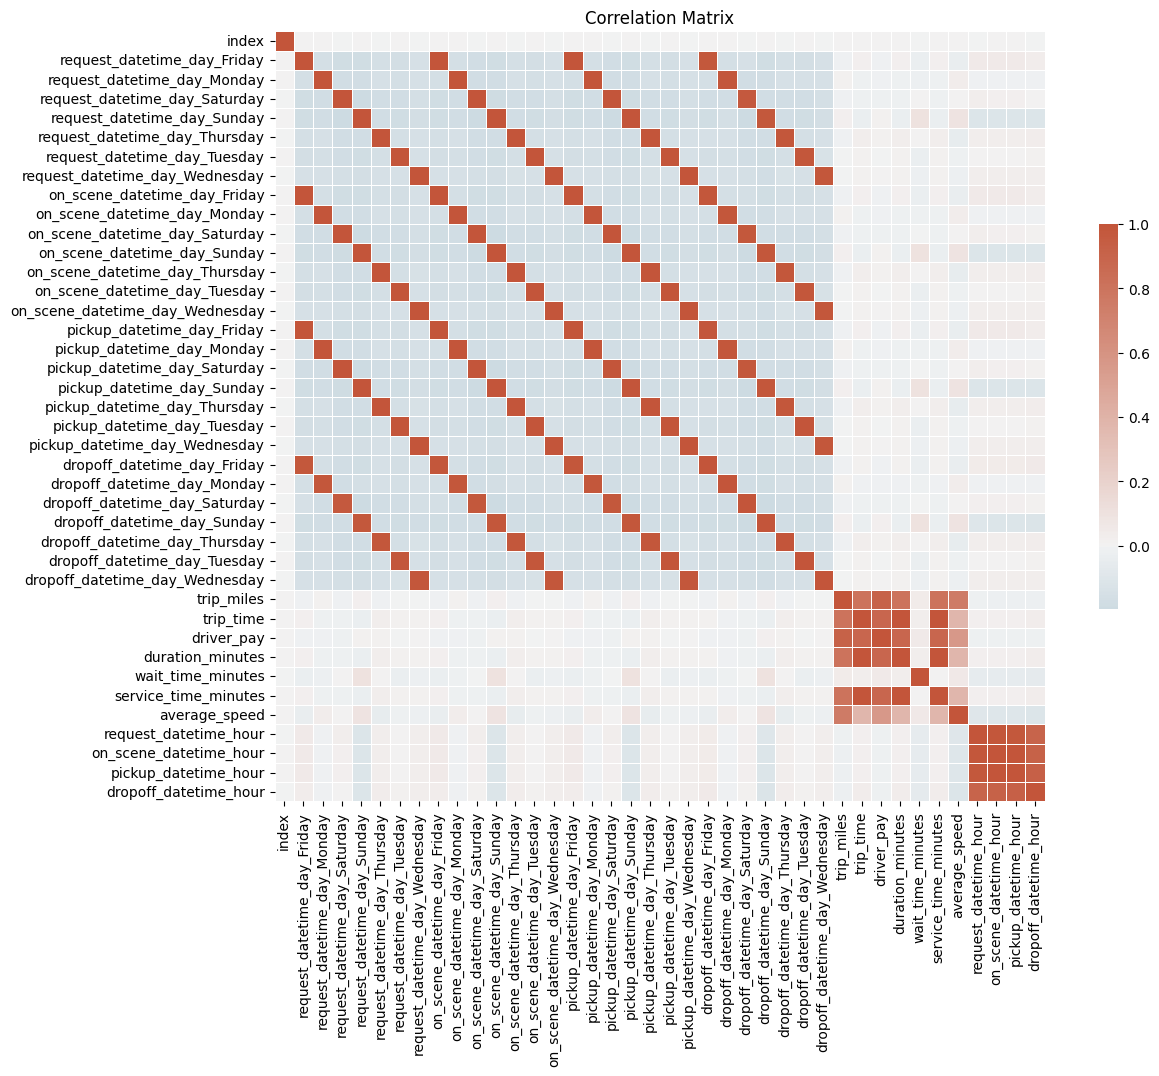

In [32]:
plot_correlation_matrix(df_numeric)

In [33]:
# file_path = r"X:\DS\NYC MLOPS\data\raw\df_output.parquet"

In [34]:

# df.to_parquet(file_path)

In [35]:
# parquet_table = pq.read_table(file_path)
# df=parquet_table.to_pandas()

In [36]:
# Store df in Mongo DB
# import json
# records=json.loads(df.T.to_json()).values()

Save to MongoDB

In [37]:
# import pymongo
# client = pymongo.MongoClient('mongodb://localhost:27017/')

# db=client["NYC_Taxi"]
# col=db["rides"]
# col.insert_many(records)

Read from MongoDB

In [38]:
# import pymongo
# import pandas as pd

# client = pymongo.MongoClient('mongodb://localhost:27017/')
# db = client["NYC_Taxi"]
# col = db["rides"]

# documents = list(col.find({}, no_cursor_timeout=True))

# df = pd.DataFrame(documents)
# df.drop('_id', axis=1, inplace=True)

In [39]:
# df=df.sample(frac=0.01)

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [42]:
df.drop(columns='index',inplace=True)

C:\Users\Home\AppData\Local\Temp\ipykernel_30264\2364643253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='index',inplace=True)


In [43]:
X = df.drop(columns='driver_pay')
y = df['driver_pay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X

,request_datetime_day_Friday,request_datetime_day_Monday,request_datetime_day_Saturday,request_datetime_day_Sunday,request_datetime_day_Thursday,request_datetime_day_Tuesday,request_datetime_day_Wednesday,on_scene_datetime_day_Friday,on_scene_datetime_day_Monday,on_scene_datetime_day_Saturday,...,trip_miles,trip_time,duration_minutes,wait_time_minutes,service_time_minutes,average_speed,request_datetime_hour,on_scene_datetime_hour,pickup_datetime_hour,dropoff_datetime_hour
0,1,0,0,0,0,0,0,1,0,0,...,-0.385345,-0.402716,-0.402696,-0.577226,-0.238047,-0.253798,-0.369708,-0.390001,-0.367653,-0.366041
1,0,0,1,0,0,0,0,0,0,1,...,-0.642830,-0.937370,-0.937362,-0.789754,-0.846484,-0.368500,-1.918924,-1.953794,-1.912358,-1.890699
3,0,0,1,0,0,0,0,0,0,1,...,-0.381794,-0.054788,-0.054760,-0.620822,-0.032175,-0.646327,-0.369708,-0.390001,-0.367653,-0.213575
5,1,0,0,0,0,0,0,1,0,0,...,-0.500770,-0.872889,-0.872880,-0.555428,-0.859597,0.329732,1.024587,1.017413,1.022581,1.006151
6,0,0,0,0,0,0,1,0,0,0,...,-0.616194,-0.733181,-0.733168,1.346422,-0.783542,-0.657880,-1.144316,-1.171898,-1.140006,-1.128370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369572,0,0,0,1,0,0,0,0,0,0,...,0.346267,0.530913,0.530955,1.471759,0.449067,0.311464,-2.073846,-2.110174,-2.066829,-1.890699
369573,0,0,1,0,0,0,0,0,0,1,...,-0.443945,-0.632429,-0.632415,-0.353800,-0.649791,-0.059909,-0.524629,-0.546380,-0.522124,-0.518506
369576,1,0,0,0,0,0,0,1,0,0,...,0.031958,-0.596159,-0.596143,-0.593574,-0.643235,1.839553,0.714744,0.704654,0.713640,0.701220
369577,0,0,0,0,0,0,1,0,0,0,...,4.164146,3.346579,3.346684,1.117546,3.336519,1.905497,0.869666,1.017413,1.022581,1.158617


In [45]:
# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
# Predict and evaluate
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(0.15159299719647198, 0.9141500099900338)

-----

In [26]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

ModuleNotFoundError: No module named 'pyarrow.parquet'

In [2]:
parquet_table = pq.read_table(r'X:\DS\NYC MLOPS\data\transformed\X\fhvhv_tripdata_2023-01.parquet')
# parquet_table = pq.read_table(r'X:\DS\NYC MLOPS\data\remote\yellow_tripdata_2023-06.parquet')
df=parquet_table.to_pandas()

In [3]:
df

,trip_miles,trip_time,duration_minutes,wait_time_minutes,service_time_minutes,average_speed,request_datetime_hour,on_scene_datetime_hour,pickup_datetime_hour,dropoff_datetime_hour,...,pickup_datetime_day_Thursday,pickup_datetime_day_Tuesday,pickup_datetime_day_Wednesday,dropoff_datetime_day_Friday,dropoff_datetime_day_Monday,dropoff_datetime_day_Saturday,dropoff_datetime_day_Sunday,dropoff_datetime_day_Thursday,dropoff_datetime_day_Tuesday,dropoff_datetime_day_Wednesday
0,-0.282147,-0.289027,-0.288993,-0.631662,-0.062475,-0.086749,11,11,11,11,...,0,0,0,1,0,0,0,0,0,0
1,-0.726089,-1.001626,-1.001594,-0.869288,-0.883697,-0.228003,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2,-0.276024,0.174700,0.174735,-0.680406,0.215395,-0.570141,11,11,11,12,...,0,0,0,0,0,1,0,0,0,0
3,-0.481155,-0.915684,-0.915652,-0.607290,-0.901395,0.631855,20,20,20,20,...,0,0,0,1,0,0,0,0,0,0
4,-0.680164,-0.729477,-0.729445,1.519160,-0.798743,-0.584368,6,6,6,6,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239763,3.036700,2.294594,2.294633,-0.625569,2.360481,1.479860,22,22,22,23,...,0,0,0,0,0,1,0,0,0,0
239764,-0.667917,-1.014159,-1.015917,0.233541,-0.896086,0.093103,19,19,19,19,...,0,0,0,1,0,0,0,0,0,0
239765,0.529195,-0.451958,-0.451924,0.069031,-0.526182,2.397726,15,15,15,15,...,0,0,0,0,0,0,1,0,0,0
239766,-0.383182,-0.595194,-0.595161,-0.381850,-0.618216,0.152020,10,10,10,10,...,0,0,0,0,0,1,0,0,0,0


In [50]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,239758,239759,239760,239761,239762,239763,239764,239765,239766,239767
trip_miles,-0.282147,-0.726089,-0.276024,-0.481155,-0.680164,-0.524019,-0.28827,-0.738335,1.671197,-0.937344,...,-0.389305,1.609963,0.073006,0.847608,3.91846,3.0367,-0.667917,0.529195,-0.383182,0.743512
trip_time,-0.289027,-1.001626,0.1747,-0.915684,-0.729477,-0.084915,0.266013,-0.625631,2.751159,-1.280936,...,0.616941,1.159448,1.848771,0.271384,3.773506,2.294594,-1.014159,-0.451958,-0.595194,0.018931
duration_minutes,-0.288993,-1.001594,0.174735,-0.915652,-0.729445,-0.084881,0.266048,-0.625598,2.751199,-1.280905,...,0.616977,1.159485,1.84881,0.271419,3.773548,2.294633,-1.015917,-0.451924,-0.595161,0.018965
wait_time_minutes,-0.631662,-0.869288,-0.680406,-0.60729,1.51916,0.31275,0.617399,-0.704778,0.19089,-0.826637,...,-1.088635,-0.387943,-0.741336,0.002008,1.653205,-0.625569,0.233541,0.069031,-0.38185,-0.174689
service_time_minutes,-0.062475,-0.883697,0.215395,-0.901395,-0.798743,-0.177517,0.217165,-0.619985,2.825958,-1.172186,...,0.626005,1.252541,1.838369,0.249022,3.753372,2.360481,-0.896086,-0.526182,-0.618216,0.043717
average_speed,-0.086749,-0.228003,-0.570141,0.631855,-0.584368,-0.852886,-0.662157,-0.914023,0.055411,-0.707615,...,-1.028818,1.176355,-0.950628,1.313662,1.070771,1.47986,0.093103,2.397726,0.15202,1.603259
dropoff_datetime,2023-01-20 11:43:39,2023-01-21 01:10:14,2023-01-07 12:02:26,2023-01-06 20:47:54,2023-01-04 06:54:38,2023-01-22 16:13:32,2023-01-19 16:54:34,2023-01-14 10:54:09,2023-01-10 08:04:55,2023-01-23 19:00:48,...,2023-01-27 14:47:51,2023-01-11 08:32:51,2023-01-21 14:07:46,2023-01-28 21:30:00,2023-01-16 16:28:54,2023-01-28 23:32:48,2023-01-20 19:46:58,2023-01-29 15:56:19,2023-01-07 10:44:06,2023-01-24 06:33:29
request_datetime_hour,11,1,11,20,6,15,16,10,7,18,...,14,8,13,21,15,22,19,15,10,6
on_scene_datetime_hour,11,1,11,20,6,15,16,10,7,18,...,14,8,13,21,15,22,19,15,10,6
pickup_datetime_hour,11,1,11,20,6,15,16,10,7,18,...,14,8,13,21,15,22,19,15,10,6


-----

In [19]:
import pandas as pd

keys_list = [
    'trip_miles', 'trip_time', 'duration_minutes', 'wait_time_minutes', 'service_time_minutes', 'average_speed', 
    'request_datetime_hour', 'on_scene_datetime_hour', 'pickup_datetime_hour', 'dropoff_datetime_hour', 
    'access_a_ride_flag_ ', 'access_a_ride_flag_N', 'request_datetime_day_Friday', 'request_datetime_day_Monday', 
    'request_datetime_day_Saturday', 'request_datetime_day_Sunday', 'request_datetime_day_Thursday', 
    'request_datetime_day_Tuesday', 'request_datetime_day_Wednesday', 'on_scene_datetime_day_Friday', 
    'on_scene_datetime_day_Monday', 'on_scene_datetime_day_Saturday', 'on_scene_datetime_day_Sunday', 
    'on_scene_datetime_day_Thursday', 'on_scene_datetime_day_Tuesday', 'on_scene_datetime_day_Wednesday', 
    'pickup_datetime_day_Friday', 'pickup_datetime_day_Monday', 'pickup_datetime_day_Saturday', 
    'pickup_datetime_day_Sunday', 'pickup_datetime_day_Thursday', 'pickup_datetime_day_Tuesday', 
    'pickup_datetime_day_Wednesday', 'dropoff_datetime_day_Friday', 'dropoff_datetime_day_Monday', 
    'dropoff_datetime_day_Saturday', 'dropoff_datetime_day_Sunday', 'dropoff_datetime_day_Thursday', 
    'dropoff_datetime_day_Tuesday', 'dropoff_datetime_day_Wednesday'
]


def map_data_to_df(input_data):
    # Creating a base DataFrame with all zeros
    df_mapped = pd.DataFrame(columns=keys_list)
    df_mapped.loc[0] = [0] * len(keys_list)
    
    # Mapping direct values
    for key, value in input_data.items():
        if key in df_mapped.columns:
            df_mapped[key] = value
    

    if 'access_a_ride_flag' in input_data:
        column_name = f"access_a_ride_flag_{input_data['access_a_ride_flag'].strip()}"
        if column_name in df_mapped.columns:
            df_mapped[column_name] = 1
    
    # One-hot encoding '*_datetime_day' columns
    days_columns = ['request_datetime_day', 'on_scene_datetime_day', 'pickup_datetime_day', 'dropoff_datetime_day']
    for col in days_columns:
        if col in input_data:
            column_name = f"{col}_{input_data[col]}"
            if column_name in df_mapped.columns:
                df_mapped[column_name] = 1
                
    return df_mapped

input_data = {
    "trip_miles": 10.5,
    "trip_time": 45.0,
    "driver_pay": 30.0,
    "access_a_ride_flag": " ",
    "request_datetime_hour": 10,
    "request_datetime_day": "Monday",
    "duration_minutes": 25.5,
    "wait_time_minutes": -5.5,
    "service_time_minutes": 15.0,
    "on_scene_datetime_hour": 11,
    "on_scene_datetime_day": "Monday",
    "pickup_datetime_hour": 12,
    "pickup_datetime_day": "Monday",
    "dropoff_datetime_hour": 12,
    "dropoff_datetime_day": "Monday",
    "average_speed": 0.5
}

df_mapped = map_data_to_df(input_data)


In [20]:
df_mapped.shape

(1, 40)